In [2]:
import numpy as np

# Numerical Solution of 1D Heat Equation 

(This is warm-up for callable bond pricing -- the relvent equation there is also a parabolic PDE.)

We aim to solve
$$\begin{gather}
u_t = a u_{xx} \\
 x\in [0,L] \\
 t\in [0,T] \\
 u(0,x) = f(x) \\
 u(t,0) = l(x) \\
 u(t,L) = r(x)
\end{gather}$$

We'll do this via the Crank-Nicolson discretization scheme. 

## Index Notation

$$
  u_{i,j} = u(i\Delta_t, j\Delta_x),\qquad i=1,\dots,n,\, j=1,\dots,m.
$$
Since $n\Delta_t=T$ we have $\Delta_t=T/n$. Simlarly $\Delta_x=L/m$.

## Discretization
1. Time derivative is centered midway between $i$ and $i+1$:
$$
   u_t\bigr|_{((i+0.5)\Delta_t, j\Delta_x)} = \frac{u_{i+1,j} - u_{i,j}}{\Delta_t} + O(\Delta_t^2)
$$
1. Space derivative is average of the second-order differences at $i$ and $i+1$:
$$
  u_{xx}\bigr|_{((i+0.5)\Delta_t, j\Delta_x)} = \frac 12\left[ 
      \frac {u_{i,j+1} - 2u_{i,j} + u_{i,j-1} }{\Delta_x^2} + \frac {u_{i+1,j+1} - 2u_{i+1,j} + u_{i+1,j-1}}{\Delta_x^2} 
  \right] + O(\Delta_x^2)
$$
1. Dropping the error terms and putting into the PDE gives:
$$
   \frac{u_{i+1,j} - u_{i,j}}{\Delta_t} = \frac a2\left[ 
      \frac {u_{i,j+1} - 2u_{i,j} + u_{i,j-1} }{\Delta_x^2} + \frac {u_{i+1,j+1} - 2u_{i+1,j} + u_{i+1,j-1}}{\Delta_x^2} 
  \right]
$$
1. Let $\gamma=\frac a2 \frac {\Delta_t}{\Delta_x^2}$:
$$
u_{i+1,j} - u_{i,j} = \gamma\left[ 
      u_{i,j+1} - 2u_{i,j} + u_{i,j-1}  + u_{i+1,j+1} - 2u_{i+1,j} + u_{i+1,j-1} 
  \right]
$$
1. Now collect the $i+1$ terms on the LHS:
$$
u_{i+1,j} -\gamma\left[u_{i+1,j+1} - 2u_{i+1,j} + u_{i+1,j-1}\right]  = u_{i,j} + \gamma\left[ 
      u_{i,j+1} - 2u_{i,j} + u_{i,j-1}   
  \right]
$$
1. Collecting futher on the $u$ terms:
$$
 -\gamma u_{i+1,j-1} + (1+2\gamma)u_{i+1,j} -\gamma u_{i+1,j+1} = 
  \gamma u_{i,j-1} + (1-2\gamma)u_{i,j} + \gamma u_{i,j+1} 
$$

This is a tri-diagonal matrix equation, which is efficiently solved.

## Boundary Conditions

Recall that 
* $u_{0,j}=f(k\Delta_x)$

* $u_{i,0}=l(i\Delta_t)$

* $u_{i,m}=r(i\Delta_t)$

Let's look at solving $i=1$. The RHS here are known.

* $j=0$: $u_{1,0} = l(\Delta_t)$ (already known!)

* $j=1$: $ -\gamma u_{1,0} + (1+2\gamma)u_{1,1} -\gamma u_{1,2} = \gamma u_{0,0} + (1-2\gamma)u_{0,1} + \gamma u_{0,2}$

* $j=2$: $ -\gamma u_{1,1} + (1+2\gamma)u_{1,2} -\gamma u_{1,3} = \gamma u_{0,1} + (1-2\gamma)u_{0,2} + \gamma u_{0,3}$

* $j=m-1$: $ -\gamma u_{1,m-2} + (1+2\gamma)u_{1,m-1} -\gamma u_{1,m} = \gamma u_{0,m-2} + (1-2\gamma)u_{0,m-1} + \gamma u_{0,m}$ ($u_{1,m}$ is known!)

So to summarize, we have $m-1$ unknowns, $u_{1,j}\,j=1,\dots,m-1$. Let
$$
{\bf u_i} \equiv \left[ \begin{matrix} u_{i,1} \\ u_{i,2} \\ \vdots \\ u_{i,m-1} \end{matrix} \right]
$$

In matrix form we then have
$$
 A{\bf u_1} = B{\bf u_0} + {\bf c_0}
$$
where 
$$
A = \left[    
\begin{matrix}
1+2\gamma & -\gamma & 0 & \dots & 0 \\
-\gamma & 1+2\gamma & -\gamma & \dots & 0 \\
0 & \ddots & \ddots & \ddots & 0 \\
0 & 0& 0 &-\gamma & 1+2\gamma
\end{matrix}
\right]
$$
and
$$
B = \left[    
\begin{matrix}
1-2\gamma & \gamma & 0 & \dots & 0 \\
\gamma & 1-2\gamma & \gamma & \dots & 0 \\
0 & \ddots & \ddots & \ddots & 0 \\
0 & 0& 0 &\gamma & 1-2\gamma
\end{matrix}
\right]
$$
and
$$
 {\bf c_0} = \left[
  \begin{matrix}
  \gamma (u_{1,0}+u_{0,0}) \\
  0 \\
  \vdots \\
  0 \\
  \gamma (u_{1,m}+u_{0,m})
  \end{matrix}
 \right]
$$

In [54]:
a = 1
L = 1
T = 1
n = 40 # time steps
m = 40 # space steps
dt = T/n
dx = L/m
gam = 0.5*a*dt/dx**2
print(gam)

def f(x):
    return np.sin(0.5*x*np.pi)

def l(t):
    return f(0)*np.ones(len(t))

def r(t):
    return f(1)*np.ones(len(t))

19.999999999999996


In [55]:
# u(t,x)
xi = np.linspace(0,L,m+1)
ti = np.linspace(0,T,n+1)
u = np.zeros( (n+1, m+1) )

# Boundary conditions
u[0,:] = f(xi)
u[:,0] = l(ti)
u[:,-1] = r(ti)

# Pre-compute A and B, initialize c
A = np.diag(1+2*gam*np.ones(m-1)) + np.diag(-gam*np.ones(m-2) ,-1) + np.diag(-gam*np.ones(m-2), 1)
B = np.diag(1-2*gam*np.ones(m-1)) + np.diag(gam*np.ones(m-2) ,-1) + np.diag(gam*np.ones(m-2), 1)
c = np.zeros(m-1)

In [56]:
# Iteratively solve
for i in range(1,n+1):
    #print('i=%d'%i)
    c[0] = gam*(u[i-1,0] + u[i,0])
    c[-1] = gam*(u[i-1,-1] + u[i,-1])    
    u[i,1:-1] = np.linalg.solve(A,B.dot(u[i-1,1:-1])+c)

In [11]:
u

array([[ 0.        ,  0.01      ,  0.04      ,  0.09      ,  0.16      ,
         0.25      ,  0.36      ,  0.49      ,  0.64      ,  0.81      ,
         1.        ],
       [ 0.        ,  0.07950535,  0.15291178,  0.22890055,  0.31266944,
         0.40697222,  0.51266944,  0.62890055,  0.75291178,  0.87950535,
         1.        ],
       [ 0.        ,  0.08598624,  0.1793676 ,  0.27545776,  0.37307925,
         0.47224881,  0.57307925,  0.67545776,  0.7793676 ,  0.88598624,
         1.        ],
       [ 0.        ,  0.10002118,  0.19545424,  0.29139582,  0.38899369,
         0.48822637,  0.58899369,  0.69139582,  0.79545424,  0.90002118,
         1.        ],
       [ 0.        ,  0.0965927 ,  0.19708782,  0.29740114,  0.39725924,
         0.49713563,  0.59725924,  0.69740114,  0.79708782,  0.8965927 ,
         1.        ],
       [ 0.        ,  0.10131053,  0.1996622 ,  0.29871056,  0.39847601,
         0.49846653,  0.59847601,  0.69871056,  0.7996622 ,  0.90131053,
         1.   

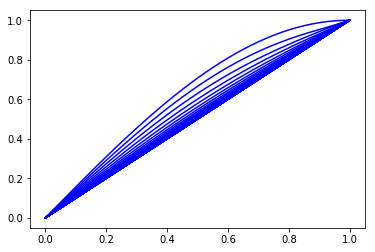

In [57]:
import matplotlib.pylab as plt
for i in range(0,n+1):
    plt.plot(ti, u[i,:],'b-')
plt.show()
